In [2]:
import openmc
import openmc.deplete
import matplotlib.pyplot as plt

In [20]:
filename = "./depletion_results/barc-v3-5-percent-waste-pu-removed"
result = openmc.deplete.Results(filename+'/depletion_results.h5')

In [21]:
problem_nuclides = ["C14","Ni59","Nb94","I129","H3","Co60",'Be8']
actinides = ["U238","U235","Pu239","Pu240","Pu241","Cm242","Am241"]
fission_products = ['Y90',"Sr90","Cs137","Tc99"]
test = ["Be8"]

try:
    times, activities = result.get_activity(mat="15",by_nuclide=True)
    times, total_activity = result.get_activity(mat="15")
except KeyError:
    times, activities = result.get_activity(mat="12",by_nuclide=True)
    times, total_activity = result.get_activity(mat="12")
    #print("Material not recognized, check id in materials.xml")

activities[0]
max_keys = [max(activities[i], key=activities[i].get) for i in range(len(activities))]
print(max_keys)


['Y90', 'Be8', 'Be8', 'Be8', 'Be8', 'Be8', 'Be8', 'Be8', 'Be8', 'Be8', 'Be8']


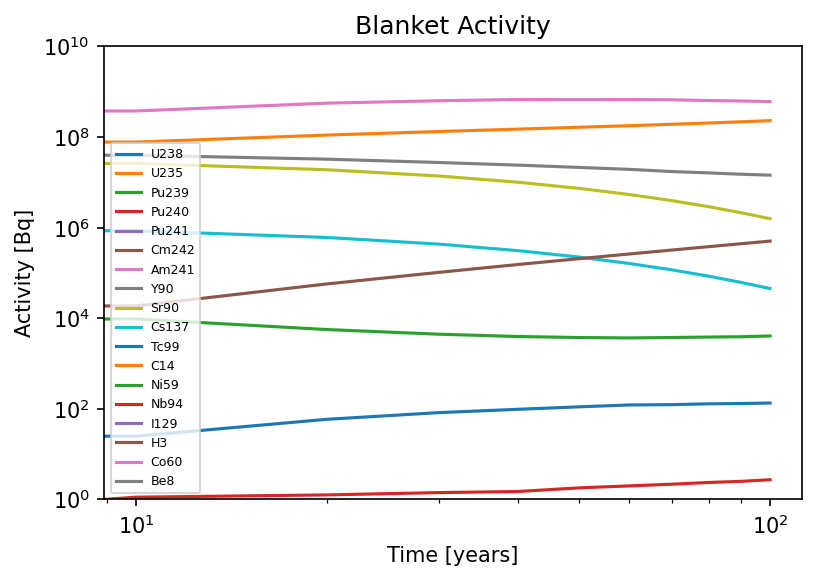

In [24]:
fig, ax = plt.subplots(dpi=150)

for i in actinides+fission_products+problem_nuclides:
    try:
        values = [ia[i] for ia in activities]
    except:
        continue
    ax.loglog(times/60/60/24/365, values, label=i)
'''
for i in test:
    values = [ia[i] for ia in activities]
    ax.plot(times/60/60/24/365, values, label=i,ls="--")

for i in problem_nuclides:
    values = [ia[i] for ia in activities]
    ax.plot(times/60/60/24/365, values, label=i,ls=":")
'''
#ax.plot(times/60/60/24/365,total_activity,label="Total Activity",ls="-.", lw=5)
ax.legend(fontsize=6)
ax.set_ylim(1e0,1e10)
plt.xlabel("Time [years]")
plt.ylabel("Activity [Bq]")
plt.title("Blanket Activity")
plt.savefig("old.png")

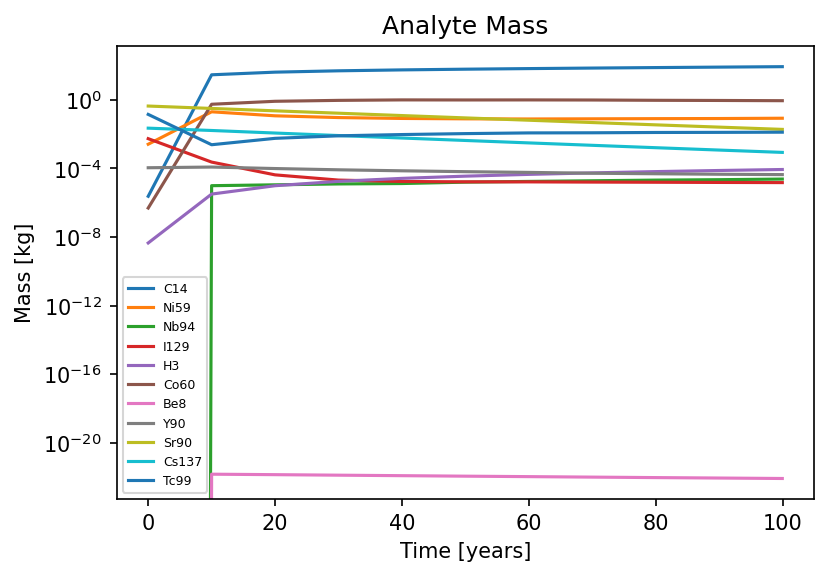

In [25]:
# plot analyte masses
fig, ax = plt.subplots(dpi=150)

for i in problem_nuclides+fission_products:
    times, mass = result.get_mass(mat='15', nuc=i, time_units='a', mass_units='kg')
    ax.semilogy(times, mass, label=i)
"""
for i in test:
    times, mass = result.get_mass(mat='12', nuc=i, time_units='a', mass_units='kg')
    ax.plot(times, mass, label=i, ls="--")
"""
ax.set_title("Analyte Mass")
ax.set_xlabel("Time [years]")
ax.set_ylabel("Mass [kg]")
ax.legend(fontsize=6)
plt.show()

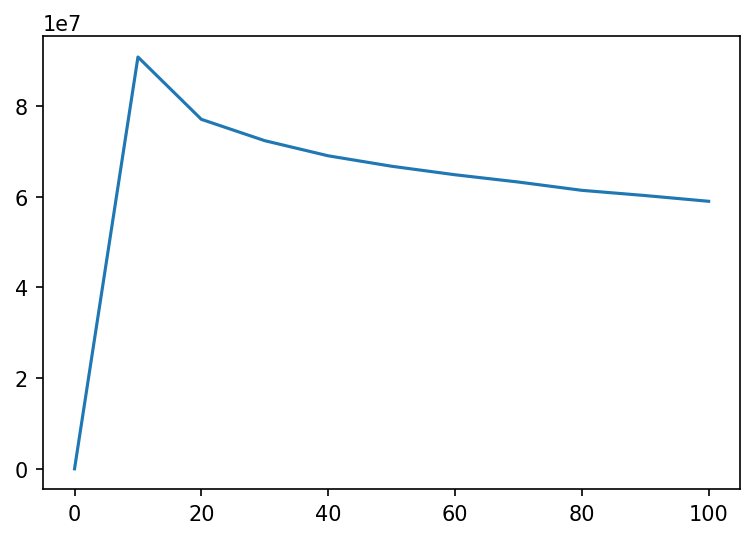

In [11]:
times, heat = result.get_decay_heat(mat='15')
fig, ax = plt.subplots(dpi=150)
ax.plot(times/60/60/24/365, heat)

In [12]:
# Export material 
from barc_blanket.materials.waste_classification import sum_of_fractions
depleted_material = result.export_to_materials(burnup_index=9, path=filename+"/materials.xml")
depleted_material
sum_of_fractions(depleted_material[5],2,3)


/home/hallj/.local/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=15.
  warn(msg, IDWarning)


(2.976015580261991,
 {'Cs137': 0.00011758708386391539,
  'Ni63': 2.9756875167136174,
  'Sr90': 0.00021047646450967413})

/home/hallj/.local/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=6.
  warn(msg, IDWarning)
/home/hallj/.local/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=7.
  warn(msg, IDWarning)
/home/hallj/.local/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=8.
  warn(msg, IDWarning)
/home/hallj/.local/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=10.
  warn(msg, IDWarning)
/home/hallj/.local/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=11.
  warn(msg, IDWarning)
/home/hallj/.local/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=12.
  warn(msg, IDWarning)
/home/hallj/.local/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: A

Time: 0 years
Table 1 sum of fractions: 57.10
Table 2 sum of fractions: 1.01
Time: 10 years
Table 1 sum of fractions: 67.76
Table 2 sum of fractions: 0.80
Time: 20 years
Table 1 sum of fractions: 79.10
Table 2 sum of fractions: 0.63
Time: 30 years
Table 1 sum of fractions: 91.11
Table 2 sum of fractions: 0.50
Time: 40 years
Table 1 sum of fractions: 103.95
Table 2 sum of fractions: 0.40
Time: 50 years
Table 1 sum of fractions: 117.52
Table 2 sum of fractions: 0.32
Time: 60 years
Table 1 sum of fractions: 131.72
Table 2 sum of fractions: 0.26
Time: 70 years
Table 1 sum of fractions: 146.56
Table 2 sum of fractions: 0.21
Time: 80 years
Table 1 sum of fractions: 162.11
Table 2 sum of fractions: 0.17
Time: 90 years
Table 1 sum of fractions: 178.58
Table 2 sum of fractions: 0.14
Time: 100 years
Table 1 sum of fractions: 195.48
Table 2 sum of fractions: 0.12
Time: 0 years
Table 1 sum of fractions: 0.00
Table 2 sum of fractions: 0.00
Time: 10 years
Table 1 sum of fractions: 0.00
Table 2 sum o

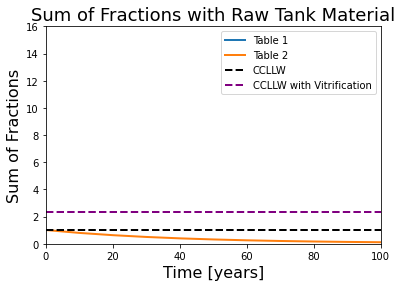

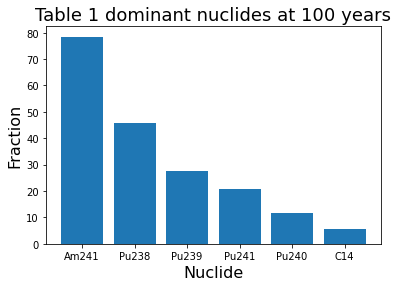

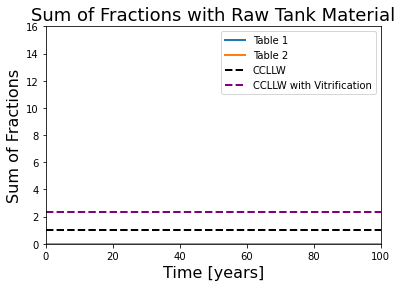

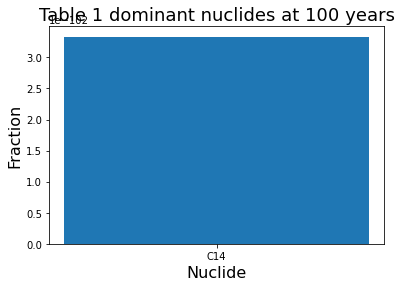

In [19]:
import openmc

from barc_blanket.materials.blanket_depletion import postprocess_coupled_depletion, plot_results
from barc_blanket.utilities import working_directory, CROSS_SECTIONS, CHAIN_FILE

openmc.config['cross_sections'] = CROSS_SECTIONS
openmc.config['chain_file'] = CHAIN_FILE

def main():
    with working_directory(filename):
        postprocess_coupled_depletion(5, 6)
        plot_results()
main()